# Did Somebody Say 'Chocolate'?
### ITCS 4156 Assignment 1
### by Sean Fox

## Data Overview

Chocolate is an enourmous industry.  According to the source of the data set, America collectively consumes over 2.8 billion pounds of chocolate a year.  However, there are brands that are clearly thought of more fondly when it comes to the quality of their chocolate.  With this data set, we aim to see if we can predict an average rating of chocolate (on a scale of 0-5) based on the attributes given to us within the dataset.

The dataset can be found here: https://www.kaggle.com/rtatman/chocolate-bar-ratings

In [282]:
#For organizational purposes, all imports can be found here:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [283]:
#The following functions is used to convert percents to decimals in the dataset
def percentToDecimal(percent):
    return float(percent.strip('%'))/100

In [329]:
original = pd.read_csv("flavors_of_cacao.csv", converters={'Cocoa\nPercent':percentToDecimal})
cocoa = original.drop("Bean\nType", axis=1)           #Dropping the Bean Type column due to too many missing entries
cocoa = cocoa.dropna(subset=["Broad Bean\nOrigin"])       #Dropping the rows with empty Broad Bean Origin entries
encoder=LabelEncoder()

cocoa.columns = ['Company (Maker-if known)', "Specific Bean Origin or Bar Name", "REF", "Review Date", "Cocoa Percent", "Company Location", "Rating", "Broad Bean Origin"]
#cocoa = cocoa.groupby('Broad Bean Origin').filter(lambda x: len(x) > 1)
cocoa.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,Peru


In [331]:
#cocoa['Broad Bean Origin'].unique()

In [332]:
cocoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1794 entries, 0 to 1794
Data columns (total 8 columns):
Company (Maker-if known)            1794 non-null object
Specific Bean Origin or Bar Name    1794 non-null object
REF                                 1794 non-null int64
Review Date                         1794 non-null int64
Cocoa Percent                       1794 non-null float64
Company Location                    1794 non-null object
Rating                              1794 non-null float64
Broad Bean Origin                   1794 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 126.1+ KB


From the output from the .info() function, we can see that this dataset has only four numerical values: REF, Review Date, CocoaPercent, and Rating.  For this analysis, we wish to see what, if any, of the fields have an effect on predicting the value of the Rating feature.  Thus, Rating will become the labels (output) of our model.  The training and test sets are built accordingly below.

In [333]:
cocoa.describe()

,REF,Review Date,Cocoa Percent,Rating
count,1794.000000,1794.000000,1794.000000,1794.000000
mean,1035.925307,2012.325530,0.716982,3.186315
std,553.039836,2.928016,0.063249,0.477921
min,5.000000,2006.000000,0.420000,1.000000
25%,576.000000,2010.000000,0.700000,3.000000
50%,1071.000000,2013.000000,0.700000,3.250000
75%,1502.000000,2015.000000,0.750000,3.500000
max,1952.000000,2017.000000,1.000000,5.000000


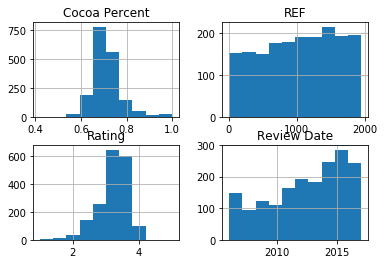

In [334]:
cocoa.hist()
plt.show()

In [335]:
corrMat = cocoa.corr()
corrMat['Rating'].sort_values(ascending=False)

Rating           1.000000
REF              0.101035
Review Date      0.099815
Cocoa Percent   -0.164877
Name: Rating, dtype: float64

While it's not a great correlation, the correlation matrix shows that Cocoa Percent is the numeric attribute with the closest relation to the Rating attribute.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000202DCB28208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000202DE1FA4A8>]], dtype=object)

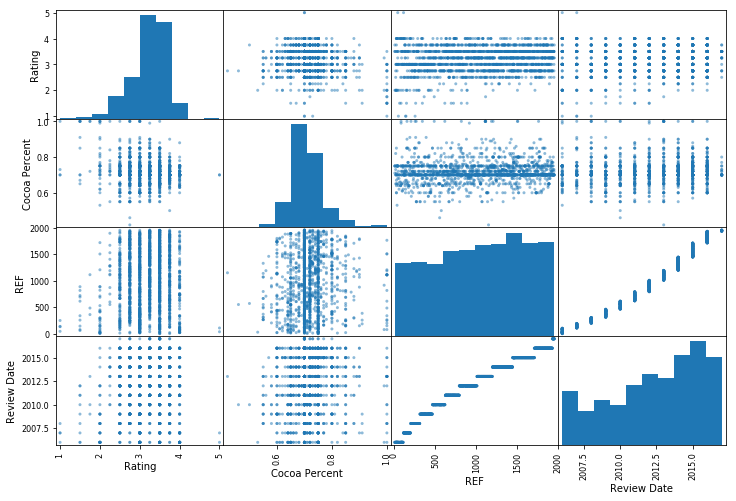

In [336]:
attributes = ["Rating", "Cocoa Percent", "REF", "Review Date"]
pd.plotting.scatter_matrix(cocoa[attributes], figsize=(12,8))

From the scatter matrix above, we can see a couple of things.  While there is a very nice linear relationship between REF and Review Date, neither of them seem to substantially effect Rating in a meaningful way.  On the other hand, there is not a linear relationship between Cocoa Percent and Rating, the darker dots in their scatter plot seem to converge towards the center, so there is some relationship between them.  For this reason, we will initially use Cocoa Percent as the input for our model and keep Rating as the labels.

In [337]:
train, test = train_test_split(cocoa, test_size = 0.33, random_state=42)

#split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(cocoa, cocoa["Broad Bean Origin"]):
#    train = cocoa.loc[train_index]
#    test = cocoa.loc[test_index]
    
cocoa = train.drop("Rating", axis=1)
trainLabels = train["Rating"].copy()
cocoaTest = test.drop("Rating", axis=1)
testLabels = test["Rating"].copy()
cocoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 1424 to 1127
Data columns (total 7 columns):
Company (Maker-if known)            1201 non-null object
Specific Bean Origin or Bar Name    1201 non-null object
REF                                 1201 non-null int64
Review Date                         1201 non-null int64
Cocoa Percent                       1201 non-null float64
Company Location                    1201 non-null object
Broad Bean Origin                   1201 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 75.1+ KB


EXPLAIN PIPELINE HERE

In [338]:
num_attribs = ["REF", "Cocoa Percent", "Review Date"]
cat_attribs = ["Company (Maker-if known)", "Specific Bean Origin or Bar Name", "Company Location", "Broad Bean Origin"]

#num_attribs = ["Cocoa Percent"]
#cat_attribs = ["Broad Bean Origin"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

cocoaPrepared = full_pipeline.fit_transform(cocoa)
cocoaTestPrepared = full_pipeline.fit_transform(cocoaTest)
percent = cocoaPrepared[:,1].reshape(-1,1)
testPercent = cocoaTestPrepared[:,1].reshape(-1,1)

## Training the Models 

For the purpose of the assignment, we will try four different model styles: linear regression, polynomial regression, decision tree regression, and random forrest regression.  As stated earlier, the Cocoa Percent and Rating relationship is likely non-linear.  However, since it is the only algorithm we have gone over in detail at this time, it would feel wrong not to at least try it.  I will also use it to describe the general process for training the model.

### Linear Regression

In [339]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [340]:
#Creating and fitting the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(percent, trainLabels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [341]:
scores = cross_val_score(lin_reg, percent, trainLabels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [ 0.48569835  0.44245996  0.46032524  0.54193437  0.48921271  0.42103916
  0.43918773  0.46285442  0.47493331  0.45037441]
Mean: 0.466801964855
Standard Deviation: 0.0321667859047


In [342]:
scores = cross_val_score(lin_reg, percent, trainLabels, scoring='neg_mean_absolute_error', cv=10)
lin_mae_scores = -scores
display_scores(lin_mae_scores)

Scores: [ 0.38762486  0.37419816  0.37428801  0.42448126  0.37293451  0.3494169
  0.36465035  0.36672225  0.39932449  0.37079753]
Mean: 0.378443832707
Standard Deviation: 0.0198344941216


### Decision Tree Regressor

In [343]:
#Creating and fitting the Decision Tree Regressor model to the training set
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(percent, trainLabels)
scores = cross_val_score(tree_reg, percent, trainLabels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 0.48671838  0.44668226  0.43927565  0.52563664  0.50276946  0.4270935
  0.40578306  0.43674627  0.44175589  0.46991167]
Mean: 0.458237277281
Standard Deviation: 0.0352437148462


In [344]:
scores = cross_val_score(tree_reg, percent, trainLabels, scoring='neg_mean_absolute_error', cv=10)
tree_mae_scores = np.sqrt(-scores)
display_scores(tree_mae_scores)

Scores: [ 0.61347978  0.60637455  0.60283137  0.64167032  0.61566958  0.59825996
  0.58360442  0.58707795  0.61202547  0.61888156]
Mean: 0.607987497604
Standard Deviation: 0.015856396995


### Random Forest Regressor 

In [345]:
forestReg = RandomForestRegressor()
forestReg.fit(percent, trainLabels)
scores = cross_val_score(forestReg, percent, trainLabels, scoring='neg_mean_squared_error', cv=10)
rand_rmse_scores = np.sqrt(-scores)
display_scores(rand_rmse_scores)

Scores: [ 0.47756022  0.44793179  0.44384913  0.52642335  0.49332388  0.42359969
  0.40162429  0.43638434  0.44796764  0.47444704]
Mean: 0.457311135838
Standard Deviation: 0.0343642193496


In [346]:
scores = cross_val_score(forestReg, percent, trainLabels, scoring='neg_mean_absolute_error', cv=10)
rand_mae_scores = np.sqrt(-scores)
display_scores(rand_rmse_scores)

Scores: [ 0.47756022  0.44793179  0.44384913  0.52642335  0.49332388  0.42359969
  0.40162429  0.43638434  0.44796764  0.47444704]
Mean: 0.457311135838
Standard Deviation: 0.0343642193496


### Summary

The results for each models were printed after each error was calculated, but a table with all of the relevant values is printed below.

In [347]:
names = ['Linear', 'Decision Tree', 'Random Forest']
rmse_mean = [lin_rmse_scores.mean(), tree_rmse_scores.mean(), rand_rmse_scores.mean()]
mae_mean = [lin_mae_scores.mean(), tree_mae_scores.mean(), rand_mae_scores.mean()]
rmse_std = [lin_rmse_scores.std(), tree_rmse_scores.std(), rand_rmse_scores.std()]
mae_std = [lin_mae_scores.std(), tree_mae_scores.std(), rand_mae_scores.std()]


titles = ['Model', 'RSME Mean', 'RMSE Std. Dev.', 'MAE Mean', 'MAE Std. Dev.']
data = [titles] + list(zip(names, rmse_mean, rmse_std, mae_mean, mae_std))
print("Mean Error for each Model\n")
for i, d in enumerate(data):
    line = '|'.join(str(x).ljust(15) for x in d)
    print(line)
    if i == 0:
        print('-' * len(line))

Mean Error for each Model

Model          |RSME Mean      |RMSE Std. Dev. |MAE Mean       |MAE Std. Dev.  
-------------------------------------------------------------------------------
Linear         |0.466801964855 |0.0321667859047|0.378443832707 |0.0198344941216
Decision Tree  |0.458237277281 |0.0352437148462|0.607987497604 |0.015856396995 
Random Forest  |0.457311135838 |0.0343642193496|0.607403340062 |0.0146824601015


Looking at the two means, RMSE is very similar for all three models.  According to RMSE, Random Forest has the smallest mean, but Linear Regression has the smallest standard deviation.  However, this still means that Random Forest can achieve the smallest error according to RMSE - though not by much.

It's a different story when we examine the MAE results.  This time, Linear Regression has the smallest possible error  with Decision Tree and Random Forest being a little less than twice as large.  Linear Regression still has the largest standard deviation this time, but the difference between the three is still not large meaning that Linear Regression effectively has the least amount of error according to MAE.

So what does all of this mean?  Well, p-norms (RSME is the 2-norm while MAE is the 1-norm) put more weight on the outliers in a data set.  Linear Regression is the only one whose error increases from the jump to MAE to RSME which tells us that its outliers have more error than with the other two models.  As a result, moving forward, I will work with Random Forest on the test data.  It is not perfect, but I believe it is showing the most promise of the three.

For visualization purposes, I have created scatter plots of the Rating and Cocoa Percent attributes and placed representations of all three models over them.

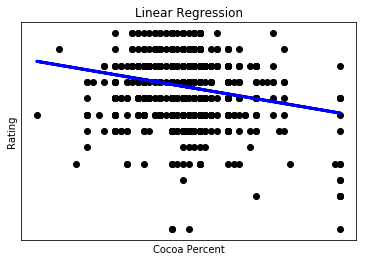

In [348]:
plt.scatter(percent, trainLabels,  color='black')
plt.plot(percent, lin_reg.predict(percent), color='blue', linewidth=3)

plt.title("Linear Regression")
plt.xticks(())
plt.yticks(())
plt.xlabel("Cocoa Percent")
plt.ylabel("Rating")
plt.show()

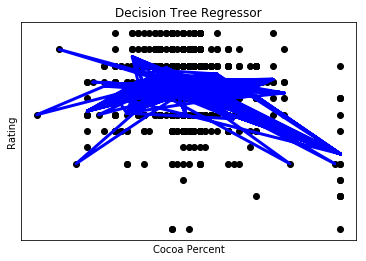

In [349]:
plt.scatter(percent, trainLabels,  color='black')
plt.plot(percent, tree_reg.predict(percent), color='blue', linewidth=3)
plt.title("Decision Tree Regressor")
plt.xticks(())
plt.yticks(())
plt.xlabel("Cocoa Percent")
plt.ylabel("Rating")
plt.show()

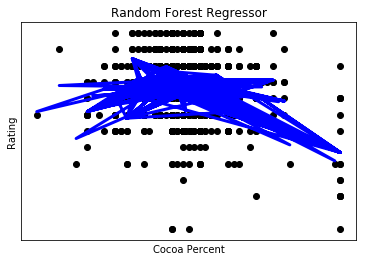

In [350]:
plt.scatter(percent, trainLabels,  color='black')
plt.plot(percent, forestReg.predict(percent), color='blue', linewidth=3)
plt.title("Random Forest Regressor")
plt.xticks(())
plt.yticks(())
plt.xlabel("Cocoa Percent")
plt.ylabel("Rating")
plt.show()

## Fine Tune the Model

In [359]:
#Fine tuning the hyperparameters
param_grid = [
    # try 3 (3×1) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [1]},
    # then try 2 (2×1) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [1]},
  ]

forestReg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forestReg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(percent, trainLabels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [360]:
grid_search.best_params_

{'max_features': 1, 'n_estimators': 30}

In [356]:
finalModel = grid_search.best_estimator_

finalPredictions = finalModel.predict(percent)
finalMSE = mean_squared_error(trainLabels,finalPredictions)
finalRMSE = np.sqrt(finalMSE)
finalRMSE

0.44039102517328349

Comparing this new RMSE error to that of the previous one (0.457311135838 ), we see that these is a very slight improvement, but not by much.  Repeating the procedure on the test data, we get the following:

In [357]:
finalPredictions = finalModel.predict(testPercent)
finalMSE = mean_squared_error(testLabels,finalPredictions)
finalRMSE = np.sqrt(finalMSE)
finalRMSE

0.47427280674082534

## Presenting the Solution and Future of the System 

Our findings show that there is not a strong correlation between the percent of cocoa within chocolate and the rating of the quality of that chocolate.  I still believe a relation is there, but we would need to either bring in more data, use additional attributes from the existing data, or try a new model entirely.  We saw earlier that the three models I used produced similar error according to RMSE and that the relationship between the cocoa percentage and rating was not entirely linear.  This tells me that none of the three models stood out to be the best possible match for this data set. Our current solution is not great, but it does predict the rating withing .5 points, so it could be a lot worse.

For future test, I would like to analyze the Broad Bean Origin attribute.  I think that one would be the next most likely to affect the rating, but that's jsut a guess.  The problem is that the data associated with that attribute is not consistent.  Sometimes it's a single country, and other times it's several.  That makes formatting very difficult which is why it was not already incorporated with this project.  As much as I would hate to do it, I suspect that it may need to be, at least somewhat, manually examined to determine if it's better to convert those multi-country attributes or just remove them entirely.  In addition, there are several countries that appear a lot more than others (for example, Japan only appears about four times), and I do not know how much that would affect the bias of our chosen model.  There are several things to consider before just thowing in another attribute.

## Appendix

The following code was retrieved from the notebook pages supplied for this class, and more details can be found there.  They are used to support the pipelines written in block following it.

In [354]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values